In [1]:
%load_ext lab_black

In [2]:
from datetime import date, timedelta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
df_btc = pd.read_csv("gemini_BTCUSD_day.csv", header=1)
df_eth = pd.read_csv("gemini_ETHUSD_day.csv", header=1)
df_sol = pd.read_csv("solana_investingcom.csv", header=0)

currency = pd.read_csv("FRB.csv")
sp500 = pd.read_csv("HistoricalData_spx.csv")
nasdaq = pd.read_csv("HistoricalData_comp.csv")

### preprocessing 

In [4]:
def preprocess_gemini_data(df):
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    df = df[["date", "symbol", "open", "high", "low", "close", "volume"]].copy()
    df.date = pd.to_datetime(df.date).dt.date
    df.index = df.date
    df = df.drop(columns="date")
    return df


def preprocess_solana(df):
    df.columns = df.columns.str.lower()
    df.date = pd.to_datetime(df.date)
    df.index = df.date
    return df


def preprocess_currency_data_to_series(currency, col_number):
    euro = currency.iloc[6:, [0, col_number]]
    euro.columns = ["date", "price"]
    euro.date = pd.to_datetime(euro.date, errors="coerce")
    euro.price = pd.to_numeric(euro.price, errors="coerce")
    euro.index = euro.date
    euro = euro.price.dropna()
    return euro


def preprocess_ns_data_to_series(df):
    s = df[["Date", "Open"]]
    s.columns = s.columns.str.lower()
    s.index = pd.to_datetime(s.date)
    s = s.open
    return s

In [5]:
df_btc = preprocess_gemini_data(df_btc)
df_eth = preprocess_gemini_data(df_eth)
df_sol = preprocess_solana(df_sol)

btc = df_btc.open
eth = df_eth.open
sol = df_sol.open

sp500 = preprocess_ns_data_to_series(sp500)
nasdaq = preprocess_ns_data_to_series(nasdaq)
currency = preprocess_currency_data_to_series(currency, 2)

In [6]:
ana = pd.concat(
    [
        btc.rename("btc"),
        eth.rename("eth"),
        sol.rename("sol"),
        sp500.rename("sp500"),
        nasdaq.rename("nas"),
        currency.rename("eur"),
    ],
    axis=1,
    join="outer",
)
# ana = ana.dropna(axis=0)[1:].copy()

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexes/base.py:3512: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = self._engine.get_indexer(target._get_engine_target())
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/pandas/core/algorithms.py:1799: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  sorter = values.argsort()
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in orde

In [7]:
ana.corr()

,btc,eth,sol,sp500,nas,eur
btc,1.000000,0.927863,0.649573,0.899899,0.904439,0.346107
eth,0.927863,1.000000,0.899620,0.863726,0.836676,0.314734
sol,0.649573,0.899620,1.000000,0.809123,0.775379,-0.703472
sp500,0.899899,0.863726,0.809123,1.000000,0.986500,0.255733
nas,0.904439,0.836676,0.775379,0.986500,1.000000,0.304599
eur,0.346107,0.314734,-0.703472,0.255733,0.304599,1.000000


### daily return

In [17]:
def daily_comparrision(coin):
    comp = ana[[coin, "sp500", "nas"]].replace(0, np.nan).dropna()
    comp["month"] = (
        pd.Series(comp.index).dt.year * 100 + pd.Series(comp.index).dt.month
    ).values
    for c in [coin, "sp500", "nas"]:
        comp[f"ret_1d_{c}"] = (
            (comp[c] / comp[c].shift(1))
            .replace([np.inf, -np.inf], np.nan)
            .fillna(
                1,
            )
        )
    return comp

In [18]:
comp = daily_comparrision("btc")
comp.iloc[:, -3:].corr()

,ret_1d_btc,ret_1d_sp500,ret_1d_nas
ret_1d_btc,1.000000,0.148955,0.120340
ret_1d_sp500,0.148955,1.000000,0.859469
ret_1d_nas,0.120340,0.859469,1.000000


In [19]:
comp["ret_1d_btc_sp500"] = comp.ret_1d_btc / comp.ret_1d_sp500
comp["ret_1d_btc_nas"] = comp.ret_1d_btc / comp.ret_1d_nas

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexes/base.py:1963: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_monotonic_increasing


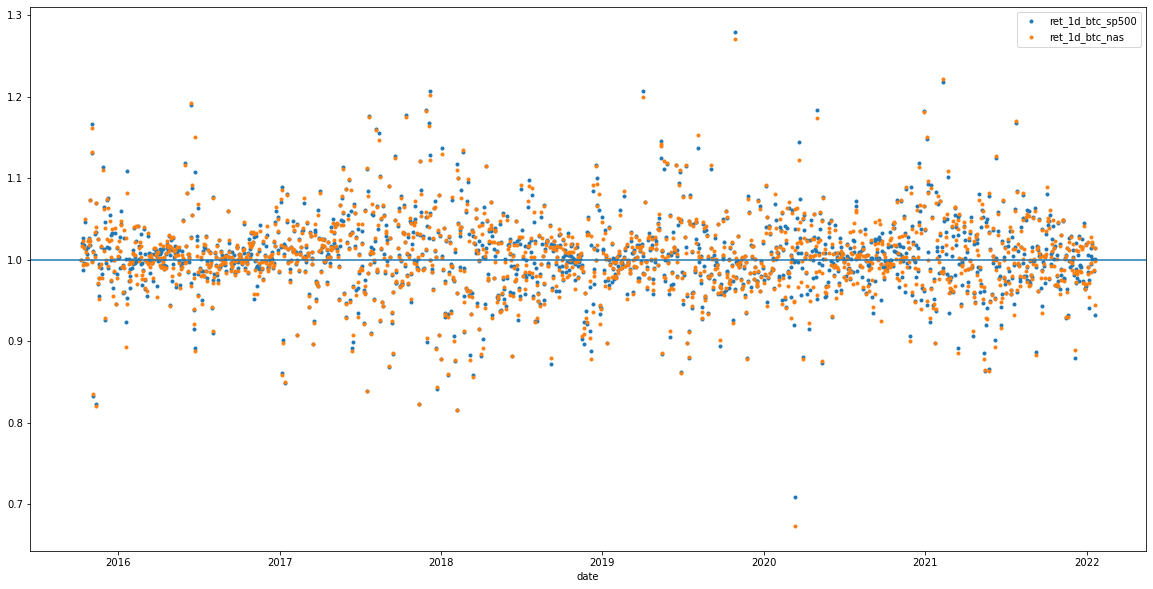

In [20]:
fig = plt.figure(figsize=(20, 10))
comp.ret_1d_btc_sp500.plot(
    marker=".",
    linestyle="none",
)
comp.ret_1d_btc_nas.plot(
    marker=".",
    linestyle="none",
)
plt.axhline(y=1)

plt.legend()

### monthly return

In [21]:
def monthly_comparrision(coin):
    comp = daily_comparisson(coin)
    comp_month = comp.groupby(by="month")[
        f"ret_1d_{coin}", "ret_1d_sp500", "ret_1d_nas"
    ].prod()
    comp_month.columns = [f"ret_1m_{coin}", "ret_1m_sp500", "ret_1m_nas"]
    return comp_month

In [22]:
comp_month = monthly_comparrision("btc")
comp_month.corr()

/var/folders/y2/kn_782d959q_kshjqj842tpc0000gn/T/ipykernel_85641/371806628.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  comp_month = comp.groupby(by="month")[f"ret_1d_{coin}", "ret_1d_sp500", "ret_1d_nas"].prod()


,ret_1m_btc,ret_1m_sp500,ret_1m_nas
ret_1m_btc,1.000000,0.276353,0.239605
ret_1m_sp500,0.276353,1.000000,0.940072
ret_1m_nas,0.239605,0.940072,1.000000


In [109]:
comp_month["ret_1m_btc_sp500"] = comp_month.ret_1m_btc / comp_month.ret_1m_sp500
comp_month["ret_1m_btc_nas"] = comp_month.ret_1m_btc / comp_month.ret_1m_nas
comp_month.index = [date(x // 100, x % 100, 1) for x in comp_month.index]

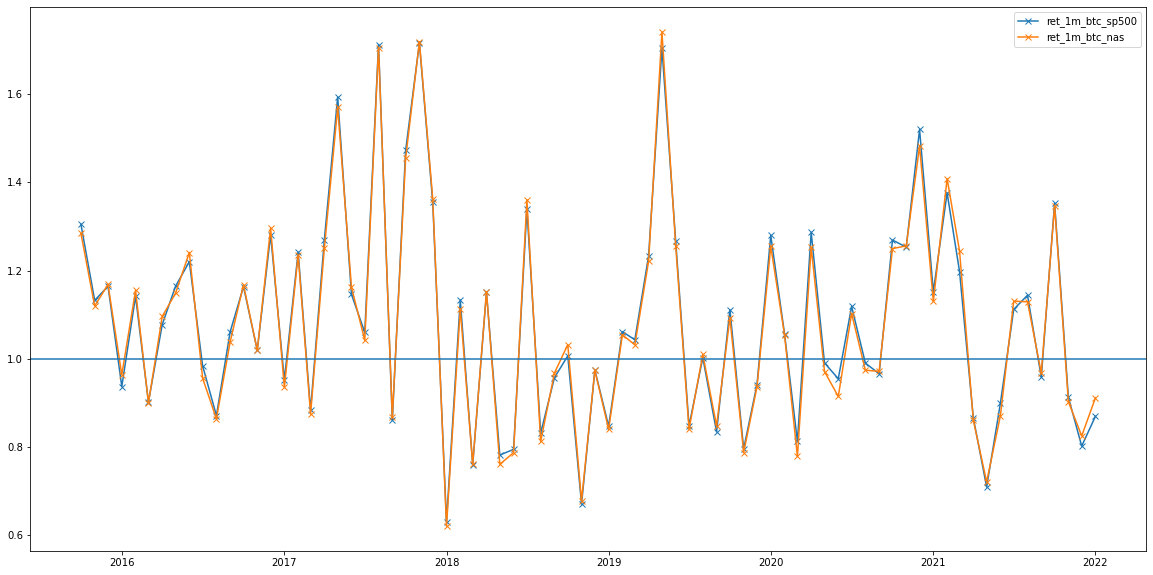

In [117]:
fig = plt.figure(figsize=(20, 10))
comp_month.ret_1m_btc_sp500.plot(
    marker="x",
    # linestyle="none",
)
comp_month.ret_1m_btc_nas.plot(
    marker="x",
    # linestyle="none",
)
plt.axhline(y=1)

plt.legend()

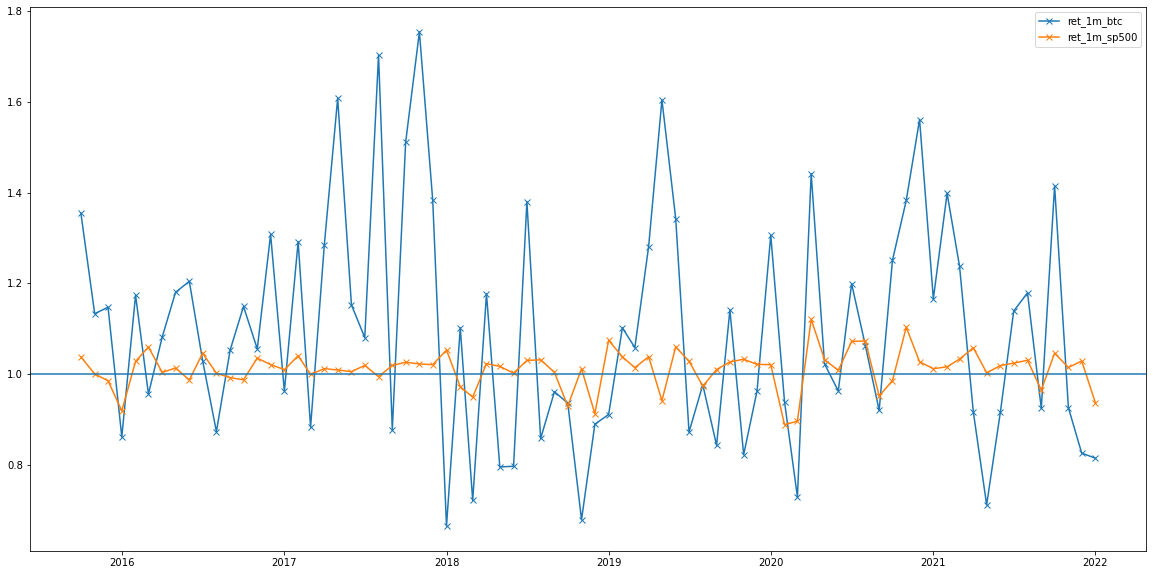

In [118]:
fig = plt.figure(figsize=(20, 10))
comp_month.ret_1m_btc.plot(
    marker="x",
    # linestyle="none",
)
comp_month.ret_1m_sp500.plot(
    marker="x",
    # linestyle="none",
)
plt.axhline(y=1)

plt.legend()

In [128]:
btc_relative_increase = (comp_month.ret_1m_btc - 1) / (comp_month.ret_1m_btc - 1).max()
sp500_relative_increase = (comp_month.ret_1m_sp500 - 1) / (
    comp_month.ret_1m_sp500 - 1
).max()
nasdaq_relative_increase = (comp_month.ret_1m_nas - 1) / (
    comp_month.ret_1m_nas - 1
).max()

relative_increase_df = pd.concat(
    [btc_relative_increase, sp500_relative_increase, nasdaq_relative_increase], axis=1
)

In [130]:
relative_increase_df.corr()

,ret_1m_btc,ret_1m_sp500,ret_1m_nas
ret_1m_btc,1.000000,0.276353,0.239605
ret_1m_sp500,0.276353,1.000000,0.940072
ret_1m_nas,0.239605,0.940072,1.000000


In [141]:
same = ((relative_increase_df > 0).sum(axis=1) == 3) | (
    (relative_increase_df > 0).sum(axis=1) == 0
)

In [143]:
relative_increase_df.loc[~same].shape

(34, 3)

In [136]:
len(relative_increase_df)

76

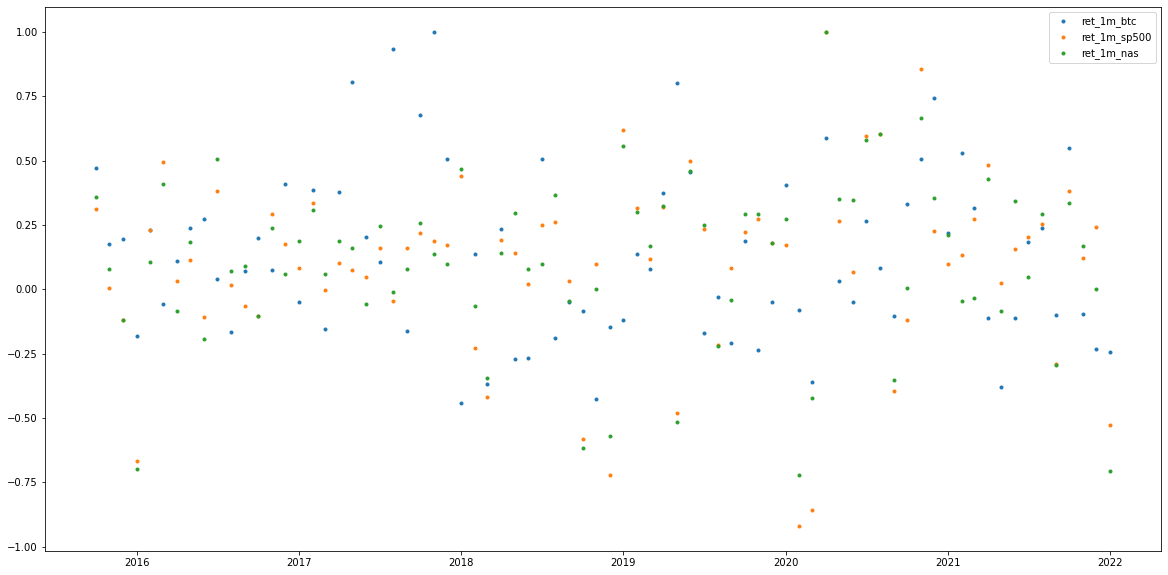

In [127]:
fig = plt.figure(figsize=(20, 10))
btc_relative_increase.plot(
    marker=".",
    linestyle="none",
)
sp500_relative_increase.plot(
    marker=".",
    linestyle="none",
)
nasdaq_relative_increase.plot(
    marker=".",
    linestyle="none",
)

plt.legend()